In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 100)
import scipy
from gensim.models import Word2Vec
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Msi-1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Msi-1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Msi-1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Задачу в этом модуле я буду решать методом классификации, т.к. важно не столько угадать правильный рейтинг сам по себе, более важно точно угадывать высокий рейтинг, что позволит рекомендовать пользователю максимально то, что ему нравится.

In [3]:
ratings = pd.read_csv('ratings.csv')
ratings

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


<Axes: xlabel='rating', ylabel='Count'>

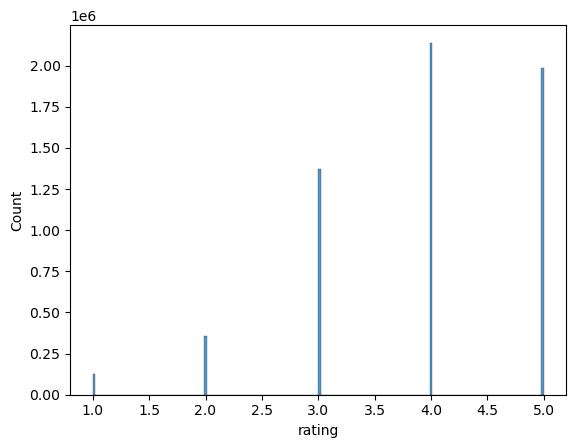

In [5]:
sns.histplot(ratings.rating)

In [5]:
book_tags = pd.read_csv('book_tags.csv')
book_tags

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
...,...,...,...
999907,33288638,21303,7
999908,33288638,17271,7
999909,33288638,1126,7
999910,33288638,11478,7


In [7]:
tags = pd.read_csv('tags.csv')
tags

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-
...,...,...
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ


In [9]:
tag_merge = book_tags.merge(tags, how='left')
tag_merge.drop(columns=['tag_id'], inplace=True)
tag_merge

,goodreads_book_id,count,tag_name
0,1,167697,to-read
1,1,37174,fantasy
2,1,34173,favorites
3,1,12986,currently-reading
4,1,12716,young-adult
...,...,...,...
999907,33288638,7,neighbors
999908,33288638,7,kindleunlimited
999909,33288638,7,5-star-reads
999910,33288638,7,fave-author


In [11]:
best_tags = tag_merge.groupby('tag_name').sum().sort_values(by=['count'], ascending=False).iloc[:100,:].index
best_tags

Index(['to-read', 'currently-reading', 'favorites', 'fiction', 'fantasy',
       'young-adult', 'classics', 'books-i-own', 'romance', 'owned', 'ya',
       'mystery', 'non-fiction', 'historical-fiction', 'series',
       'science-fiction', 'sci-fi', 'paranormal', 'kindle', 'contemporary',
       'book-club', 'library', 'favourites', 'owned-books', 'horror',
       'default', 'audiobook', 'urban-fantasy', 'nonfiction', 'to-buy',
       'adult', 'classic', 'childrens', 'graphic-novels', 'thriller',
       'audiobooks', 'ebook', 'vampires', 'adventure', 'history', 'dystopian',
       'audio', 'historical', 'humor', 'novels', 'chick-lit', 'literature',
       'dystopia', 'my-books', 'paranormal-romance', 'children', 'ebooks',
       'magic', 'crime', 'comics', 'i-own', 'memoir', 'read-in-2015',
       'adult-fiction', 'children-s', 'sci-fi-fantasy', 'wish-list',
       'biography', 'my-library', 'read-in-2016', 'read-in-2014',
       'children-s-books', 'supernatural', 'manga', 'philosophy

In [13]:
# Выберем наиболее популярные и подходящие теги для создания фичей
best_tags = [ 'fiction', 'fantasy',
              'young-adult', 'classics',  'romance',
              'mystery', 'non-fiction', 'historical-fiction', 
              'science-fiction', 'sci-fi', 'paranormal', 'kindle', 'contemporary',
              'horror',
              'urban-fantasy', 
              'adult', 'childrens', 'graphic-novels', 'thriller',
              'vampires', 'adventure', 'history', 'dystopian',
              'humor', 'novels', 'chick-lit',
              'paranormal-romance',
              'magic', 'crime', 'comics', 'memoir', 
              'adult-fiction', 'biography',
              'supernatural', 'manga', 'philosophy', 'teen',
              'science', 
              'suspense', 'poetry', 
              'realistic-fiction', 'short-stories', 'drama']

In [15]:
tag_merge = tag_merge[tag_merge.tag_name.isin(best_tags)]
tag_merge

,goodreads_book_id,count,tag_name
1,1,37174,fantasy
4,1,12716,young-adult
5,1,9954,fiction
12,1,3374,magic
13,1,2408,childrens
...,...,...,...
999832,33288638,29,chick-lit
999842,33288638,21,fiction
999869,33288638,12,humor
999877,33288638,10,drama


In [17]:
tag_merge = pd.get_dummies(tag_merge, columns=['tag_name'], prefix='book', dtype='int64')
tag_merge

,goodreads_book_id,count,book_adult,book_adult-fiction,book_adventure,book_biography,book_chick-lit,book_childrens,book_classics,book_comics,book_contemporary,book_crime,book_drama,book_dystopian,book_fantasy,book_fiction,book_graphic-novels,book_historical-fiction,book_history,book_horror,book_humor,book_kindle,book_magic,book_manga,book_memoir,book_mystery,book_non-fiction,book_novels,book_paranormal,book_paranormal-romance,book_philosophy,book_poetry,book_realistic-fiction,book_romance,book_sci-fi,book_science,book_science-fiction,book_short-stories,book_supernatural,book_suspense,book_teen,book_thriller,book_urban-fantasy,book_vampires,book_young-adult
1,1,37174,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,12716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,1,9954,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,3374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,2408,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999832,33288638,29,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
999842,33288638,21,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
999869,33288638,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
999877,33288638,10,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
tag_merge.iloc[:,2:] = tag_merge.iloc[:,2:].multiply(tag_merge['count'], axis="index") 
tag_merge

,goodreads_book_id,count,book_adult,book_adult-fiction,book_adventure,book_biography,book_chick-lit,book_childrens,book_classics,book_comics,book_contemporary,book_crime,book_drama,book_dystopian,book_fantasy,book_fiction,book_graphic-novels,book_historical-fiction,book_history,book_horror,book_humor,book_kindle,book_magic,book_manga,book_memoir,book_mystery,book_non-fiction,book_novels,book_paranormal,book_paranormal-romance,book_philosophy,book_poetry,book_realistic-fiction,book_romance,book_sci-fi,book_science,book_science-fiction,book_short-stories,book_supernatural,book_suspense,book_teen,book_thriller,book_urban-fantasy,book_vampires,book_young-adult
1,1,37174,0,0,0,0,0,0,0,0,0,0,0,0,37174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,12716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12716
5,1,9954,0,0,0,0,0,0,0,0,0,0,0,0,0,9954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,3374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,2408,0,0,0,0,0,2408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999832,33288638,29,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
999842,33288638,21,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
999869,33288638,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
999877,33288638,10,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# Создадим фичи отражающие количество тегов встречающихся на одну книгу
tag_merge = tag_merge.groupby('goodreads_book_id')[tag_merge.iloc[:,2:].columns].sum().reset_index()
tag_merge

,goodreads_book_id,book_adult,book_adult-fiction,book_adventure,book_biography,book_chick-lit,book_childrens,book_classics,book_comics,book_contemporary,book_crime,book_drama,book_dystopian,book_fantasy,book_fiction,book_graphic-novels,book_historical-fiction,book_history,book_horror,book_humor,book_kindle,book_magic,book_manga,book_memoir,book_mystery,book_non-fiction,book_novels,book_paranormal,book_paranormal-romance,book_philosophy,book_poetry,book_realistic-fiction,book_romance,book_sci-fi,book_science,book_science-fiction,book_short-stories,book_supernatural,book_suspense,book_teen,book_thriller,book_urban-fantasy,book_vampires,book_young-adult
0,1,0,0,1742,0,0,2408,958,0,289,0,0,0,37174,9954,0,0,0,0,0,347,3374,0,0,465,0,744,673,0,0,0,0,334,0,0,0,0,484,0,600,0,547,0,12716
1,2,0,0,0,0,0,0,0,0,0,0,0,0,3441,972,0,0,0,0,0,371,253,0,0,447,0,764,688,0,0,0,0,213,199,0,0,0,473,0,613,0,562,0,865
2,3,0,0,2430,0,0,3828,1898,0,397,0,0,0,47478,13239,0,0,0,0,0,528,4302,0,0,657,0,1082,923,0,0,0,0,0,0,0,0,0,608,0,667,0,664,0,14984
3,5,0,0,1982,0,0,2960,1090,0,324,0,0,0,39330,10656,0,0,0,0,0,403,3618,0,0,526,0,845,720,0,0,0,0,0,0,0,0,0,520,0,566,0,584,0,12856
4,6,0,0,1892,0,0,2656,1032,0,301,0,0,0,38378,10249,0,0,0,0,0,387,0,0,0,493,0,826,702,0,0,0,0,0,0,0,0,0,491,0,581,0,568,0,12979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,31538647,0,0,0,0,0,43,0,0,0,0,0,0,893,233,0,0,0,0,0,205,97,0,0,0,0,6,11,0,0,0,0,0,0,0,0,247,10,0,6,0,10,0,193
9996,31845516,31,0,0,80,0,0,0,0,9,0,0,0,0,8,0,0,0,0,0,30,0,0,432,0,392,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,32075671,0,0,0,0,0,0,0,0,1130,56,31,0,0,696,0,0,0,0,0,74,0,0,0,0,0,39,0,0,0,0,373,37,0,0,0,0,0,0,168,0,0,0,2010
9998,32848471,55,14,0,0,23,0,0,0,8,0,14,0,0,11,0,0,0,0,29,56,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0


In [25]:
books = pd.read_csv('books.csv')
books

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,"Bayou Moon (The Edge, #2)",eng,4.09,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,"Means of Ascent (The Years of Lyndon Johnson, #2)",eng,4.25,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,The Mauritius Command,eng,4.35,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,Cinderella Ate My Daughter: Dispatches from th...,eng,3.65,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


In [27]:
# Разделим датасет на обучающую и тренировочную выборки
train_df, test_df, train_y, test_y = train_test_split(ratings[['user_id', 'book_id']], ratings.rating, train_size=0.8)

# Создадим фичу отражающую средний бал поставленный пользователем
general = pd.concat([train_df, train_y], axis=1)
average = general.groupby('user_id').mean().reset_index()[['user_id', 'rating']]
average.rename(columns={'rating': 'rating_average'}, inplace=True)
train_df = train_df.merge(average, how='left')

train_df = train_df.merge(books[['book_id', 'goodreads_book_id']], left_on='book_id', right_on='book_id', how='left')
# Добавим фичи связанные с книгами
train_df = train_df.merge(tag_merge,  how='left')
# Добавим фичи связанные с пользователем
s = train_df.iloc[:,4:] > 0
s = s.astype('int64')
s['user_id'] = train_df.user_id
users_profiles = s.groupby('user_id').sum()
users_profiles.columns = ['user_'+name for name in list(users_profiles)]
train_df = train_df.merge(users_profiles, left_on='user_id', right_on='user_id', how='left')
train_df

,user_id,book_id,rating_average,goodreads_book_id,book_adult,book_adult-fiction,book_adventure,book_biography,book_chick-lit,book_childrens,book_classics,book_comics,book_contemporary,book_crime,book_drama,book_dystopian,book_fantasy,book_fiction,book_graphic-novels,book_historical-fiction,book_history,book_horror,book_humor,book_kindle,book_magic,book_manga,book_memoir,book_mystery,book_non-fiction,book_novels,book_paranormal,book_paranormal-romance,book_philosophy,book_poetry,book_realistic-fiction,book_romance,book_sci-fi,book_science,book_science-fiction,book_short-stories,book_supernatural,book_suspense,book_teen,book_thriller,book_urban-fantasy,book_vampires,book_young-adult,user_book_adult,user_book_adult-fiction,user_book_adventure,user_book_biography,user_book_chick-lit,user_book_childrens,user_book_classics,user_book_comics,user_book_contemporary,user_book_crime,user_book_drama,user_book_dystopian,user_book_fantasy,user_book_fiction,user_book_graphic-novels,user_book_historical-fiction,user_book_history,user_book_horror,user_book_humor,user_book_kindle,user_book_magic,user_book_manga,user_book_memoir,user_book_mystery,user_book_non-fiction,user_book_novels,user_book_paranormal,user_book_paranormal-romance,user_book_philosophy,user_book_poetry,user_book_realistic-fiction,user_book_romance,user_book_sci-fi,user_book_science,user_book_science-fiction,user_book_short-stories,user_book_supernatural,user_book_suspense,user_book_teen,user_book_thriller,user_book_urban-fantasy,user_book_vampires,user_book_young-adult
0,24099,1506,3.819149,1427,28,12,8,0,0,0,14,0,71,0,19,0,12,146,0,0,0,0,0,16,0,0,0,9,0,117,0,0,121,0,8,72,0,0,0,0,0,0,0,0,0,0,0,82,79,78,0,2,7,17,0,60,67,27,0,26,93,0,32,16,3,2,91,9,0,0,80,4,83,9,1,3,0,7,22,16,7,16,2,11,73,9,74,6,1,15
1,6436,1,3.981982,2767052,0,0,3190,0,0,0,0,0,382,0,340,12985,10836,13819,0,0,0,0,0,1985,0,0,0,0,0,904,0,0,0,0,0,3341,6211,0,8772,0,0,641,1776,800,0,0,25968,51,35,45,10,17,56,84,0,38,8,32,5,57,105,0,43,30,7,30,79,16,0,12,22,21,71,14,4,16,16,24,32,13,11,15,14,12,11,29,11,11,4,72
2,19442,74,3.718447,99561,0,0,0,0,0,0,0,0,3108,0,231,0,0,3372,0,0,0,0,0,431,0,0,0,372,0,256,0,0,0,0,1240,1877,0,0,0,0,0,0,678,0,0,0,9825,78,65,51,7,9,13,50,3,60,17,40,16,61,96,3,34,23,5,14,92,26,0,5,38,13,83,14,0,18,0,23,42,45,24,46,6,15,19,19,26,11,0,41
3,45991,36,4.375000,3636,0,0,250,0,0,108,540,0,98,0,104,450,252,642,0,0,0,0,0,0,0,0,0,0,0,0,0,0,177,0,0,0,203,0,351,0,0,0,485,0,0,0,271,8,4,50,0,18,12,6,0,52,1,17,23,55,78,0,14,4,8,16,71,35,0,0,34,1,29,42,25,1,3,28,68,28,0,26,3,37,7,77,9,34,9,77
4,42533,1901,4.611765,7304203,431,80,50,0,0,0,0,0,66,0,0,46,1555,241,0,0,0,0,0,195,247,0,0,97,0,0,1377,722,0,0,0,939,0,0,0,0,206,41,0,0,1820,46,38,40,39,37,0,18,1,0,0,59,1,7,11,83,84,0,9,0,25,2,77,72,0,0,39,2,20,80,80,0,0,0,83,21,0,16,2,80,23,45,7,80,67,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4781178,4547,305,4.128713,10583,131,92,0,0,0,0,46,0,39,0,0,0,290,1773,0,0,0,6222,0,44,0,0,0,138,0,111,221,0,0,0,0,0,30,0,44,0,195,154,0,426,0,0,0,64,55,64,8,0,41,68,2,29,14,26,11,71,96,2,33,24,17,16,76,26,1,4,33,16,76,23,5,10,9,15,23,39,14,39,10,26,23,23,27,19,5,57
4781179,16377,505,4.485915,27523,59,58,41,0,0,0,0,0,23,0,14,44,231,111,0,0,0,0,0,67,0,0,0,37,0,60,0,0,0,0,0,0,62,0,87,0,15,41,0,108,0,0,19,95,84,52,10,16,37,104,2,76,22,53,14,74,135,2,59,42,19,35,117,21,1,13,38,30,109,23,3,28,14,30,39,36,18,41,14,21,28,14,32,13,5,71
4781180,12018,76,3.554217,14935,368,282,0,0,244,0,0,0,0,0,153,0,0,5117,0,1155,97,0,0,0,0,0,0,0,0,435,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,78,75,16,12,31,2,30,0,61,13,58,0,31,82,0,63,49,7,5,74,5,0,7,32,15,74,14,5,6,1,26,51,8,2,8,5,9,23,1,14,2,1,21
4781181,31546,14,4.329545,7613,521,380,0,0,0

In [76]:
# Функция очистки текста
def text_cleaner(text):
    # Преобразование текста в нижний регистр
    text = text.lower()

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)

    # Преобразование сокращений
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)

    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]

    # Лемматизация слов
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    # Объединение лемматизированных слов обратно в текст
    cleaned_text = ' '.join(lemmatized_text)

    return cleaned_text

In [31]:
# Подготовим Название книг к векторизации
books['original_title'] = books['original_title'].astype('str').map(lambda texts : text_cleaner(texts))
sentences = [text.split() for text in books['original_title']]

# Векторизация
w2v_model = Word2Vec(sentences=sentences, min_count=1, vector_size=10)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=10)
w2v_model.save('title_vecs.npy')
w2v_model = Word2Vec.load('title_vecs.npy')

title_vecs = []
for title in books['original_title']:
    
    
    vec = np.mean([w2v_model.wv[word] for word in title.split() if word in w2v_model.wv], axis=0)
    
    title_vecs.append(vec)
    

df = pd.DataFrame([pd.Series(x) for x in title_vecs])
df.columns = ['vectors_{}'.format(x+1) for x in df.columns]
df


C:\Users\Msi-1\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Msi-1\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,vectors_1,vectors_2,vectors_3,vectors_4,vectors_5,vectors_6,vectors_7,vectors_8,vectors_9,vectors_10
0,0.165996,-0.070750,0.103763,0.079595,0.063804,0.088013,0.217190,0.147010,-0.393055,-0.200027
1,0.144122,-0.052243,0.189516,-0.032115,0.271996,0.165726,0.299905,0.150883,-0.512545,-0.171825
2,0.113910,-0.049707,0.068875,-0.094102,0.123659,0.174197,0.168175,0.158983,-0.354111,-0.103129
3,0.105520,0.020766,0.093100,-0.024280,0.091881,0.101293,0.190802,0.038296,-0.234014,-0.095487
4,0.196898,-0.083325,0.238251,0.021513,0.341936,0.243090,0.244786,0.154323,-0.576985,-0.237550
...,...,...,...,...,...,...,...,...,...,...
9995,0.129798,-0.056573,0.140981,0.029682,0.074925,0.127392,0.144291,0.110902,-0.279266,-0.077326
9996,-0.005712,0.010200,-0.009274,-0.009381,-0.014011,0.030852,0.113309,0.016080,-0.082367,-0.067113
9997,0.062524,0.052249,0.046060,0.020636,0.066121,0.030900,0.022573,0.054890,-0.009000,0.014198
9998,0.119198,-0.045443,0.108719,-0.006583,0.131057,0.104394,0.210394,0.125340,-0.334519,-0.130195


In [33]:
books = pd.concat([books, df], axis=1)
books

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,vectors_1,vectors_2,vectors_3,vectors_4,vectors_5,vectors_6,vectors_7,vectors_8,vectors_9,vectors_10
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,hunger game,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,0.165996,-0.070750,0.103763,0.079595,0.063804,0.088013,0.217190,0.147010,-0.393055,-0.200027
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,harry potter philosopher stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,0.144122,-0.052243,0.189516,-0.032115,0.271996,0.165726,0.299905,0.150883,-0.512545,-0.171825
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,0.113910,-0.049707,0.068875,-0.094102,0.123659,0.174197,0.168175,0.158983,-0.354111,-0.103129
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,kill mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,0.105520,0.020766,0.093100,-0.024280,0.091881,0.101293,0.190802,0.038296,-0.234014,-0.095487
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,great gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,0.196898,-0.083325,0.238251,0.021513,0.341936,0.243090,0.244786,0.154323,-0.576985,-0.237550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,bayou moon,"Bayou Moon (The Edge, #2)",eng,4.09,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...,0.129798,-0.056573,0.140981,0.029682,0.074925,0.127392,0.144291,0.110902,-0.279266,-0.077326
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,mean ascent,"Means of Ascent (The Years of Lyndon Johnson, #2)",eng,4.25,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,-0.005712,0.010200,-0.009274,-0.009381,-0.014011,0.030852,0.113309,0.016080,-0.082367,-0.067113
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,mauritius command,The Mauritius Command,eng,4.35,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...,0.062524,0.052249,0.046060,0.020636,0.066121,0.030900,0.022573,0.054890,-0.009000,0.014198
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,cinderella ate daughter dispatch frontlines ne...,Cinderella Ate My Daughter: Dispatches from th...,eng,3.65,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...,0.119198,-0.045443,0.108719,-0.006583,0.131057,0.104394,0.210394,0.125340,-0.334519,-0.130195


In [35]:
# Добавим в тренировочный датасет векторы названия книг и другие фичи из датасета с книгами 
train_df = train_df.merge(books[list(df.columns)+['book_id', 'average_rating', 'ratings_count', 'work_text_reviews_count', 'ratings_5']], left_on='book_id', right_on='book_id')

# Выполним окончательную очистку датасета
train_df.drop(columns=['user_id','book_id','goodreads_book_id'], inplace=True)
train_df.fillna(0, inplace=True)
train_df

,rating_average,book_adult,book_adult-fiction,book_adventure,book_biography,book_chick-lit,book_childrens,book_classics,book_comics,book_contemporary,book_crime,book_drama,book_dystopian,book_fantasy,book_fiction,book_graphic-novels,book_historical-fiction,book_history,book_horror,book_humor,book_kindle,book_magic,book_manga,book_memoir,book_mystery,book_non-fiction,book_novels,book_paranormal,book_paranormal-romance,book_philosophy,book_poetry,book_realistic-fiction,book_romance,book_sci-fi,book_science,book_science-fiction,book_short-stories,book_supernatural,book_suspense,book_teen,book_thriller,book_urban-fantasy,book_vampires,book_young-adult,user_book_adult,user_book_adult-fiction,user_book_adventure,user_book_biography,user_book_chick-lit,user_book_childrens,...,user_book_comics,user_book_contemporary,user_book_crime,user_book_drama,user_book_dystopian,user_book_fantasy,user_book_fiction,user_book_graphic-novels,user_book_historical-fiction,user_book_history,user_book_horror,user_book_humor,user_book_kindle,user_book_magic,user_book_manga,user_book_memoir,user_book_mystery,user_book_non-fiction,user_book_novels,user_book_paranormal,user_book_paranormal-romance,user_book_philosophy,user_book_poetry,user_book_realistic-fiction,user_book_romance,user_book_sci-fi,user_book_science,user_book_science-fiction,user_book_short-stories,user_book_supernatural,user_book_suspense,user_book_teen,user_book_thriller,user_book_urban-fantasy,user_book_vampires,user_book_young-adult,vectors_1,vectors_2,vectors_3,vectors_4,vectors_5,vectors_6,vectors_7,vectors_8,vectors_9,vectors_10,average_rating,ratings_count,work_text_reviews_count,ratings_5
0,3.819149,28,12,8,0,0,0,14,0,71,0,19,0,12,146,0,0,0,0,0,16,0,0,0,9,0,117,0,0,121,0,8,72,0,0,0,0,0,0,0,0,0,0,0,82,79,78,0,2,7,...,0,60,67,27,0,26,93,0,32,16,3,2,91,9,0,0,80,4,83,9,1,3,0,7,22,16,7,16,2,11,73,9,74,6,1,15,0.012312,-0.042810,0.026182,-0.029923,0.087568,-0.024405,-0.059981,-0.091396,0.066395,-0.094447,3.56,50921,2731,13251
1,3.981982,0,0,3190,0,0,0,0,0,382,0,340,12985,10836,13819,0,0,0,0,0,1985,0,0,0,0,0,904,0,0,0,0,0,3341,6211,0,8772,0,0,641,1776,800,0,0,25968,51,35,45,10,17,56,...,0,38,8,32,5,57,105,0,43,30,7,30,79,16,0,12,22,21,71,14,4,16,16,24,32,13,11,15,14,12,11,29,11,11,4,72,0.165996,-0.070750,0.103763,0.079595,0.063804,0.088013,0.217190,0.147010,-0.393055,-0.200027,4.34,4780653,155254,2706317
2,3.718447,0,0,0,0,0,0,0,0,3108,0,231,0,0,3372,0,0,0,0,0,431,0,0,0,372,0,256,0,0,0,0,1240,1877,0,0,0,0,0,0,678,0,0,0,9825,78,65,51,7,9,13,...,3,60,17,40,16,61,96,3,34,23,5,14,92,26,0,5,38,13,83,14,0,18,0,23,42,45,24,46,6,15,19,19,26,11,0,41,0.075618,-0.041262,0.030734,-0.003213,-0.026040,0.078625,-0.030910,-0.010268,-0.163152,-0.039127,4.09,783470,47128,359857
3,4.375000,0,0,250,0,0,108,540,0,98,0,104,450,252,642,0,0,0,0,0,0,0,0,0,0,0,0,0,0,177,0,0,0,203,0,351,0,0,0,485,0,0,0,271,8,4,50,0,18,12,...,0,52,1,17,23,55,78,0,14,4,8,16,71,35,0,0,34,1,29,42,25,1,3,28,68,28,0,26,3,37,7,77,9,34,9,77,0.022186,0.092530,0.105376,-0.070137,0.050995,0.036357,-0.002978,-0.081252,-0.023247,-0.094393,4.12,1296825,54084,585279
4,4.611765,431,80,50,0,0,0,0,0,66,0,0,46,1555,241,0,0,0,0,0,195,247,0,0,97,0,0,1377,722,0,0,0,939,0,0,0,0,206,41,0,0,1820,46,38,40,39,37,0,18,1,...,0,59,1,7,11,83,84,0,9,0,25,2,77,72,0,0,39,2,20,80,80,0,0,0,83,21,0,16,2,80,23,45,7,80,67,54,-0.074357,0.029741,-0.093860,-0.025600,0.005374,0.054949,-0.059646,0.029206,0.099307,-0.048796,4.46,73030,6025,49895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4781178,4.128713,131,92,0,0,0,0,46,0,39,0,0,0,290,1773,0,0,0,6222,0,44,0,0,0,138,0,111,221,0,0,0,0,0,30,0,44,0,195,154,0,426,0,0,0,64,5

In [41]:
# Повторим все шаги на тестовой выборке
test_df = test_df.merge(average, how='left')
test_df = test_df.merge(books[['book_id', 'goodreads_book_id']], left_on='book_id', right_on='book_id', how='left')


test_df = test_df.merge(tag_merge,  how='left')

s1 = test_df.iloc[:,4:] > 0
s1 = s1.astype('int64')
s1['user_id'] = test_df.user_id

users_profiles1 = s1.groupby('user_id').sum()
users_profiles1.columns = ['user_'+name for name in list(users_profiles1)]

test_df = test_df.merge(users_profiles1, left_on='user_id', right_on='user_id', how='left')

test_df = test_df.merge(books[list(df.columns)+['book_id', 'average_rating', 'ratings_count', 'work_text_reviews_count', 'ratings_5']], left_on='book_id', right_on='book_id')




test_df.drop(columns=['user_id','book_id','goodreads_book_id'], inplace=True)

test_df.fillna(0, inplace=True)
test_df


,rating_average,book_adult,book_adult-fiction,book_adventure,book_biography,book_chick-lit,book_childrens,book_classics,book_comics,book_contemporary,book_crime,book_drama,book_dystopian,book_fantasy,book_fiction,book_graphic-novels,book_historical-fiction,book_history,book_horror,book_humor,book_kindle,book_magic,book_manga,book_memoir,book_mystery,book_non-fiction,book_novels,book_paranormal,book_paranormal-romance,book_philosophy,book_poetry,book_realistic-fiction,book_romance,book_sci-fi,book_science,book_science-fiction,book_short-stories,book_supernatural,book_suspense,book_teen,book_thriller,book_urban-fantasy,book_vampires,book_young-adult,user_book_adult,user_book_adult-fiction,user_book_adventure,user_book_biography,user_book_chick-lit,user_book_childrens,...,user_book_comics,user_book_contemporary,user_book_crime,user_book_drama,user_book_dystopian,user_book_fantasy,user_book_fiction,user_book_graphic-novels,user_book_historical-fiction,user_book_history,user_book_horror,user_book_humor,user_book_kindle,user_book_magic,user_book_manga,user_book_memoir,user_book_mystery,user_book_non-fiction,user_book_novels,user_book_paranormal,user_book_paranormal-romance,user_book_philosophy,user_book_poetry,user_book_realistic-fiction,user_book_romance,user_book_sci-fi,user_book_science,user_book_science-fiction,user_book_short-stories,user_book_supernatural,user_book_suspense,user_book_teen,user_book_thriller,user_book_urban-fantasy,user_book_vampires,user_book_young-adult,vectors_1,vectors_2,vectors_3,vectors_4,vectors_5,vectors_6,vectors_7,vectors_8,vectors_9,vectors_10,average_rating,ratings_count,work_text_reviews_count,ratings_5
0,4.861111,0,0,1859,0,0,2396,1019,0,316,0,0,0,37296,10012,0,0,0,0,0,352,3414,0,0,429,0,778,704,0,0,0,0,349,0,0,0,0,475,0,649,0,543,0,12937,2,1,14,0,4,6,...,0,18,2,5,8,21,28,0,3,1,1,3,26,16,0,0,12,2,11,19,12,1,0,6,22,9,0,5,1,18,2,23,3,16,7,27,0.185577,-0.069232,0.237738,-0.036968,0.213261,0.145016,0.232226,0.156254,-0.447877,-0.176278,4.61,1746574,51942,1318227
1,4.542553,460,281,656,0,0,0,2829,0,127,0,0,0,3428,7012,0,0,0,0,4397,285,0,0,0,0,0,516,0,0,0,0,0,0,9773,224,10977,0,0,0,0,0,0,0,307,26,24,10,3,1,1,...,2,14,4,18,4,15,29,2,15,10,12,5,28,3,1,2,10,5,23,5,0,5,3,1,11,10,4,11,3,5,6,2,7,3,2,7,0.259384,-0.110795,0.283967,0.027178,0.269719,0.321115,0.448922,0.131457,-0.813426,-0.274526,4.20,936782,20345,498001
2,3.621359,0,0,14,0,120,0,0,0,423,0,0,0,0,62,0,0,0,0,26,44,0,0,0,0,0,0,0,0,0,0,96,418,0,0,0,0,0,0,27,0,0,0,524,5,3,15,0,6,1,...,0,21,2,10,4,17,26,0,2,1,3,4,25,12,0,0,12,0,7,12,9,0,0,9,24,8,0,6,0,12,2,23,4,9,3,24,-0.097178,0.095938,0.017409,0.013198,-0.072701,0.006069,-0.023369,-0.066628,0.082870,0.095953,3.72,13803,1974,3837
3,3.951456,0,0,12,0,0,0,0,0,61,65,0,0,0,97,0,0,0,0,0,18,0,0,0,526,0,0,0,0,0,0,29,15,17,0,9,0,0,49,45,74,0,0,407,18,17,12,0,5,1,...,0,9,14,6,3,7,23,0,1,1,1,4,22,1,0,0,18,0,15,4,2,0,0,4,12,5,1,5,0,2,17,4,16,1,0,7,0.178137,-0.069754,0.105998,-0.057479,0.191994,0.067882,0.114098,0.100768,-0.324174,-0.138290,3.89,19223,2335,7609
4,3.675676,112,0,0,0,0,0,6830,0,0,0,1594,0,0,1434,0,111,32,0,0,108,0,0,0,0,0,45,0,0,0,350,0,170,0,0,0,0,0,0,0,0,0,0,0,26,20,5,5,8,3,...,0,20,9,13,0,3,28,0,13,12,2,8,25,0,0,3,9,5,21,0,0,2,2,12,12,0,1,1,0,0,7,2,7,0,0,8,0.017855,-0.003163,0.051956,-0.012135,0.053853,0.064904,0.051709,0.063890,-0.099360,-0.018024,3.88,238875,4334,78902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195291,4.100000,29,0,35,0,0,0,0,0,0,0,0,0,455,183,0,0,0,0,0,25,13,0,0,0,0,10,6,0,6,0,0,41,17,20,21,0,0,0,0,0,0,0,0,20,12,17,0,2,0,...,0,3,4,2,0,13,17,0,3,3,0,9,20,10,0,0,4,4,17,2,1,3,0,0,5,13,9,13,0,1,4,0,4,1,0,6,0.099052,-0.06

In [49]:
# Обучим модель
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42, verbose=1)

classifier.fit(train_df, train_y)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 62.9min


RandomForestClassifier(criterion='entropy', random_state=42, verbose=1)

In [51]:
# Выполним предсказания
predictions = classifier.predict(test_df)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   28.2s


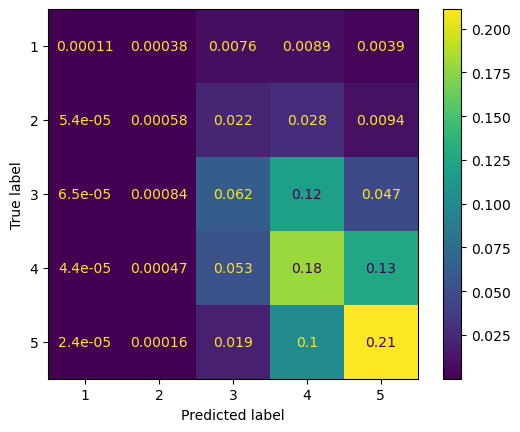

In [53]:
cm = confusion_matrix(test_y, predictions, labels=classifier.classes_, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classifier.classes_)
disp.plot()
plt.show()

In [55]:
precision_score(test_y, predictions, average='micro')

0.45353452199287875

Удалось превысить тербуемый порог по метрике precision. В целом получается, если модель оценивает книгу для пользователя как хорошую (баллы 4,5), то она ему скорее всего понравится (оценки 4,5). Это происходит в 62% случаев. Я считаю это не плохим результатом. Также можно отметить, что выше предсказываемый был, тем выше точность. Если продолжить исследование, то думаю можно было бы отобрать книги, используя, например, варианты, с наиболее высокой вероятностью выпадения 5-ки, которые с достаточно большой тоностью,  понравится пользователю(оценка 5). В таком виде это и можно было использовать на проде.

Выполним все предыдущие шаги для варианта с добавлением вектров описания книг

In [57]:
book_descr = pd.read_csv('book_descr.csv', usecols=['book_id', 'descr'])
book_descr

,book_id,descr
0,1,"In a future North America, where the rulers of..."
1,2,NaN
2,3,NaN
3,4,Harper Lee's Pulitzer Prize-winning masterwork...
4,5,A young man newly rich tries to recapture the ...
...,...,...
9995,9996,NaN
9996,9997,"In Means of Ascent, Book Two of The Years of L..."
9997,9998,NaN
9998,9999,NaN


In [59]:
book_descr['descr'] = book_descr['descr'].astype('str').map(lambda texts : text_cleaner(texts))
sentences = [text.split() for text in book_descr['descr']]

w2v_model1 = Word2Vec(sentences=sentences, min_count=1, vector_size=100)
w2v_model1.build_vocab(sentences)
w2v_model1.train(sentences, total_examples=w2v_model1.corpus_count, epochs=10)
w2v_model1.save('descr_vecs.npy')
w2v_model1 = Word2Vec.load('descr_vecs.npy')

title_vecs1 = []
for title in book_descr['descr']:
    
    
    vec = np.mean([w2v_model1.wv[word] for word in title.split() if word in w2v_model1.wv], axis=0)
    
    title_vecs1.append(vec)
    

df1 = pd.DataFrame([pd.Series(x) for x in title_vecs1])
df1.columns = ['description_{}'.format(x+1) for x in df1.columns]
df1

,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,description_10,description_11,description_12,description_13,description_14,description_15,description_16,description_17,description_18,description_19,description_20,description_21,description_22,description_23,description_24,description_25,description_26,description_27,description_28,description_29,description_30,description_31,description_32,description_33,description_34,description_35,description_36,description_37,description_38,description_39,description_40,description_41,description_42,description_43,description_44,description_45,description_46,description_47,description_48,description_49,description_50,description_51,description_52,description_53,description_54,description_55,description_56,description_57,description_58,description_59,description_60,description_61,description_62,description_63,description_64,description_65,description_66,description_67,description_68,description_69,description_70,description_71,description_72,description_73,description_74,description_75,description_76,description_77,description_78,description_79,description_80,description_81,description_82,description_83,description_84,description_85,description_86,description_87,description_88,description_89,description_90,description_91,description_92,description_93,description_94,description_95,description_96,description_97,description_98,description_99,description_100
0,-0.637588,1.141372,0.467812,-0.247625,0.359832,-1.081175,0.038417,2.066252,-0.630699,-0.550908,-0.685203,-1.218549,-0.553167,0.088054,0.519568,-0.833079,0.409049,-0.589180,0.413219,-1.858774,0.107644,-0.252871,0.936304,-0.121211,0.080023,0.207860,-0.975654,-0.703190,-0.630485,0.458445,0.908180,0.037942,0.356820,-0.682783,-0.311742,1.025785,-0.032530,0.045358,-0.332957,-1.428053,0.724939,-0.966272,-0.758425,0.339177,0.143407,-0.940324,-0.860826,-0.347379,0.256282,0.369891,0.971347,-0.891338,-0.648449,-0.396883,-1.180453,0.382720,0.458790,0.375743,-0.508496,0.016451,-0.070883,0.564236,0.561255,0.307303,-1.266008,0.755447,0.508538,0.749761,-1.205564,0.629229,-0.373172,0.732495,0.935605,-0.219520,1.278258,0.140412,-0.251351,0.084404,-0.622677,0.336015,-0.920251,-0.069334,-0.474607,1.112542,-0.005086,-0.541691,0.065945,1.086998,0.726352,0.161333,1.375953,0.406574,0.386087,-0.125253,1.473524,0.641997,0.931531,-0.661617,0.145763,0.132527
1,-0.152876,1.276216,0.295935,-0.384270,-0.032185,-1.561368,-0.056437,2.353318,-0.951067,-0.679022,-0.580931,-1.114555,0.225124,0.107687,0.610184,-0.763594,0.584098,-1.388923,-0.006132,-2.162202,0.478573,-0.356700,0.923724,-0.618284,0.036481,0.059392,-0.826588,-0.781648,-0.768267,-0.102077,1.410090,0.303618,-0.115077,-0.690401,-0.205556,1.637200,0.263121,-0.364260,-0.892131,-1.857288,0.382309,-0.889696,-0.407188,0.164586,0.587155,-0.708950,-0.934768,-0.040330,0.241259,0.516615,0.687109,-1.028170,-0.906709,-0.116323,-1.523751,0.346001,0.574245,0.572088,-0.677151,-0.178558,0.278101,0.729713,0.096567,0.684232,-1.564062,1.107047,-0.045948,0.700895,-1.248580,0.976011,-0.873300,0.630334,1.085248,-0.336821,1.147765,0.128404,-0.365632,0.219579,-0.663718,1.030637,-0.739549,-0.387125,-1.213560,1.371733,0.385377,-0.421601,-0.384661,1.550195,0.896951,0.262699,1.193791,0.361302,0.339506,0.105063,1.622504,0.984338,0.586705,-1.302214,0.266816,0.050709
2,-0.152876,1.276216,0.295935,-0.384270,-0.032185,-1.561368,-0.056437,2.353318,-0.951067,-0.679022,-0.580931,-1.114555,0.225124,0.107687,0.610184,-0.763594,0.584098,-1.388923,-0.006132,-2.162202,0.478573,-0.356700,0.923724,-0.618284,0.036481,0.059392,-0.826588,-0.781648,-0.768267,-0.102077,1.410090,0.303618,-0.115077,-0.690401,-0.205556,1.637200,0.263121,-0.364260,-0.892131,-1.857288,0.382309,-0.889696,-0.407188,0.164586,0.587155,-0.708950,-0.934768,-0.040330,0.241259,0.516615,0.687109,-1.028170,-0.906709,-0.116323,-1.523751,0.346001,0.574245,0.572088,-0.677151,-0.178558,0.278101,0.729713,0.096567,0.68

In [61]:
books = pd.concat([books, df1], axis=1)
books

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,vectors_1,vectors_2,vectors_3,vectors_4,vectors_5,vectors_6,vectors_7,vectors_8,vectors_9,vectors_10,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,description_10,description_11,description_12,description_13,description_14,description_15,description_16,description_17,...,description_51,description_52,description_53,description_54,description_55,description_56,description_57,description_58,description_59,description_60,description_61,description_62,description_63,description_64,description_65,description_66,description_67,description_68,description_69,description_70,description_71,description_72,description_73,description_74,description_75,description_76,description_77,description_78,description_79,description_80,description_81,description_82,description_83,description_84,description_85,description_86,description_87,description_88,description_89,description_90,description_91,description_92,description_93,description_94,description_95,description_96,description_97,description_98,description_99,description_100
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,hunger game,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,0.165996,-0.070750,0.103763,0.079595,0.063804,0.088013,0.217190,0.147010,-0.393055,-0.200027,-0.637588,1.141372,0.467812,-0.247625,0.359832,-1.081175,0.038417,2.066252,-0.630699,-0.550908,-0.685203,-1.218549,-0.553167,0.088054,0.519568,-0.833079,0.409049,...,0.971347,-0.891338,-0.648449,-0.396883,-1.180453,0.382720,0.458790,0.375743,-0.508496,0.016451,-0.070883,0.564236,0.561255,0.307303,-1.266008,0.755447,0.508538,0.749761,-1.205564,0.629229,-0.373172,0.732495,0.935605,-0.219520,1.278258,0.140412,-0.251351,0.084404,-0.622677,0.336015,-0.920251,-0.069334,-0.474607,1.112542,-0.005086,-0.541691,0.065945,1.086998,0.726352,0.161333,1.375953,0.406574,0.386087,-0.125253,1.473524,0.641997,0.931531,-0.661617,0.145763,0.132527
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,harry potter philosopher stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,0.144122,-0.052243,0.189516,-0.032115,0.271996,0.165726,0.299905,0.150883,-0.512545,-0.171825,-0.152876,1.276216,0.295935,-0.384270,-0.032185,-1.561368,-0.056437,2.353318,-0.951067,-0.679022,-0.580931,-1.114555,0.225124,0.107687,0.610184,-0.763594,0.584098,...,0.687109,-1.028170,-0.906709,-0.116323,-1.523751,0.346001,0.574245,0.572088,-0.677151,-0.178558,0.278101,0.729713,0.096567,0.684232,-1.564062,1.107047,-0.045948,0.700895,-1.248580,0.976011,-0.873300,0.630334,1.085248,-0.336821,1.147765,0.128404,-0.365632,0.219579,-0.663718,1.030637,-0.739549,-0.387125,-1.213560,1.371733,0.385377,-0.421601,-0.384661,1.550195,0.896951,0.262699,1.193791,0.361302,0.339506,0.105063,1.622504,0.984338,0.586705,-1.302214,0.266816,0.050709
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,0.113910,-0.049707,0.068875,-0.094102,0.123659,0.174197,0.168175,0.158983,-0.354111,-0.103129,-0.152876,1.276216,0.295935,-0.384270,-0.032185,-1.561368,-0.056437,2.353318,-0.951067,-0.679022,-0.580931,-1.114555,0.225124,0.107687,0.610184,-0.7635

In [63]:
train_df, test_df, train_y, test_y = train_test_split(ratings[['user_id', 'book_id']], ratings.rating, train_size=0.8)
general = pd.concat([train_df, train_y], axis=1)
average = general.groupby('user_id').mean().reset_index()[['user_id', 'rating']]
average.rename(columns={'rating': 'rating_average'}, inplace=True)
train_df = train_df.merge(average, how='left')

train_df = train_df.merge(books[['book_id', 'goodreads_book_id']], left_on='book_id', right_on='book_id', how='left')
train_df = train_df.merge(tag_merge,  how='left')

s = train_df.iloc[:,4:] > 0
s = s.astype('int64')
s['user_id'] = train_df.user_id
users_profiles = s.groupby('user_id').sum()
users_profiles.columns = ['user_'+name for name in list(users_profiles)]
train_df = train_df.merge(users_profiles, left_on='user_id', right_on='user_id', how='left')
train_df = train_df.merge(books[list(df.columns)+list(df1.columns)+['book_id', 'average_rating', 'ratings_count', 'work_text_reviews_count', 'ratings_5']], left_on='book_id', right_on='book_id')

train_df.drop(columns=['user_id','book_id','goodreads_book_id'], inplace=True)
train_df.fillna(0, inplace=True)
train_df

,rating_average,book_adult,book_adult-fiction,book_adventure,book_biography,book_chick-lit,book_childrens,book_classics,book_comics,book_contemporary,book_crime,book_drama,book_dystopian,book_fantasy,book_fiction,book_graphic-novels,book_historical-fiction,book_history,book_horror,book_humor,book_kindle,book_magic,book_manga,book_memoir,book_mystery,book_non-fiction,book_novels,book_paranormal,book_paranormal-romance,book_philosophy,book_poetry,book_realistic-fiction,book_romance,book_sci-fi,book_science,book_science-fiction,book_short-stories,book_supernatural,book_suspense,book_teen,book_thriller,book_urban-fantasy,book_vampires,book_young-adult,user_book_adult,user_book_adult-fiction,user_book_adventure,user_book_biography,user_book_chick-lit,user_book_childrens,...,description_55,description_56,description_57,description_58,description_59,description_60,description_61,description_62,description_63,description_64,description_65,description_66,description_67,description_68,description_69,description_70,description_71,description_72,description_73,description_74,description_75,description_76,description_77,description_78,description_79,description_80,description_81,description_82,description_83,description_84,description_85,description_86,description_87,description_88,description_89,description_90,description_91,description_92,description_93,description_94,description_95,description_96,description_97,description_98,description_99,description_100,average_rating,ratings_count,work_text_reviews_count,ratings_5
0,4.185841,73,0,0,283,190,0,0,0,53,0,0,0,0,170,0,0,0,0,117,39,0,0,921,0,1343,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,33,29,31,6,25,...,-1.523751,0.346001,0.574245,0.572088,-0.677151,-0.178558,0.278101,0.729713,0.096567,0.684232,-1.564062,1.107047,-0.045948,0.700895,-1.248580,0.976011,-0.873300,0.630334,1.085248,-0.336821,1.147765,0.128404,-0.365632,0.219579,-0.663718,1.030637,-0.739549,-0.387125,-1.213560,1.371733,0.385377,-0.421601,-0.384661,1.550195,0.896951,0.262699,1.193791,0.361302,0.339506,0.105063,1.622504,0.984338,0.586705,-1.302214,0.266816,0.050709,3.67,121373,7434,31204
1,4.448529,0,0,0,0,0,0,0,0,0,0,0,0,120,36,0,0,0,0,0,93,0,0,0,0,0,0,207,109,0,0,0,119,0,0,0,0,46,0,19,0,40,325,81,86,74,46,7,9,33,...,-1.523751,0.346001,0.574245,0.572088,-0.677151,-0.178558,0.278101,0.729713,0.096567,0.684232,-1.564062,1.107047,-0.045948,0.700895,-1.248580,0.976011,-0.873300,0.630334,1.085248,-0.336821,1.147765,0.128404,-0.365632,0.219579,-0.663718,1.030637,-0.739549,-0.387125,-1.213560,1.371733,0.385377,-0.421601,-0.384661,1.550195,0.896951,0.262699,1.193791,0.361302,0.339506,0.105063,1.622504,0.984338,0.586705,-1.302214,0.266816,0.050709,3.99,18021,691,7034
2,3.743590,145,78,24,0,0,0,63,0,32,0,31,0,2049,1711,0,142,0,2443,0,44,0,0,0,0,0,96,764,35,0,0,0,46,46,0,39,0,434,29,0,47,271,1928,0,76,67,55,7,18,34,...,-1.523751,0.346001,0.574245,0.572088,-0.677151,-0.178558,0.278101,0.729713,0.096567,0.684232,-1.564062,1.107047,-0.045948,0.700895,-1.248580,0.976011,-0.873300,0.630334,1.085248,-0.336821,1.147765,0.128404,-0.365632,0.219579,-0.663718,1.030637,-0.739549,-0.387125,-1.213560,1.371733,0.385377,-0.421601,-0.384661,1.550195,0.896951,0.262699,1.193791,0.361302,0.339506,0.105063,1.622504,0.984338,0.586705,-1.302214,0.266816,0.050709,4.05,141299,3097,57263
3,4.220183,25,19,0,0,0,0,0,0,0,165,0,0,0,290,0,0,0,0,0,33,0,0,0,461,0,0,0,0,0,0,0,0,0,0,0,0,0,104,0,240,0,0,0,98,93,45,1,38,6,...,-1.523751,0.346001,0.574245,0.572088,-0.677151,-0.178558,0.278101,0.729713,0.096567,0.684232,-1.564062,1.107047,-0.045948,0.700895,-1.248580,0.976011,-0.873300,0.630334,1.085248,-0.336821,1.147765,0.128404,-0.365632,0.219579,-0.663718,1.030637,-0.739549,-0.387125,-1.213560,1.371733,0.385377,-0.421601,-0.384661,1.550195,0.896951,0.262699,1.193791,0.361302,0.339506,0.105063,1.622504,0.984338,0.586705,-1.302214,0.266816,0.050709,3.97,37060,938,12659
4,3.125000,0,0,0,0,15,0,0,0,14,0,0,0,667,154,0,0,0,18,0,30,24,0,0,39,0,0,582,168,0,0,0,336,0,0,0,0,197,0,118

In [65]:
test_df = test_df.merge(average, how='left')
test_df = test_df.merge(books[['book_id', 'goodreads_book_id']], left_on='book_id', right_on='book_id', how='left')
test_df = test_df.merge(tag_merge,  how='left')

s1 = test_df.iloc[:,4:] > 0
s1 = s1.astype('int64')
s1['user_id'] = test_df.user_id

users_profiles1 = s1.groupby('user_id').sum()
users_profiles1.columns = ['user_'+name for name in list(users_profiles1)]
test_df = test_df.merge(users_profiles1, left_on='user_id', right_on='user_id', how='left')

test_df = test_df.merge(books[list(df.columns)+list(df1.columns)+['book_id', 'average_rating', 'ratings_count', 'work_text_reviews_count', 'ratings_5']], left_on='book_id', right_on='book_id')

test_df.drop(columns=['user_id','book_id','goodreads_book_id'], inplace=True)
test_df.fillna(0, inplace=True)
test_df

,rating_average,book_adult,book_adult-fiction,book_adventure,book_biography,book_chick-lit,book_childrens,book_classics,book_comics,book_contemporary,book_crime,book_drama,book_dystopian,book_fantasy,book_fiction,book_graphic-novels,book_historical-fiction,book_history,book_horror,book_humor,book_kindle,book_magic,book_manga,book_memoir,book_mystery,book_non-fiction,book_novels,book_paranormal,book_paranormal-romance,book_philosophy,book_poetry,book_realistic-fiction,book_romance,book_sci-fi,book_science,book_science-fiction,book_short-stories,book_supernatural,book_suspense,book_teen,book_thriller,book_urban-fantasy,book_vampires,book_young-adult,user_book_adult,user_book_adult-fiction,user_book_adventure,user_book_biography,user_book_chick-lit,user_book_childrens,...,description_55,description_56,description_57,description_58,description_59,description_60,description_61,description_62,description_63,description_64,description_65,description_66,description_67,description_68,description_69,description_70,description_71,description_72,description_73,description_74,description_75,description_76,description_77,description_78,description_79,description_80,description_81,description_82,description_83,description_84,description_85,description_86,description_87,description_88,description_89,description_90,description_91,description_92,description_93,description_94,description_95,description_96,description_97,description_98,description_99,description_100,average_rating,ratings_count,work_text_reviews_count,ratings_5
0,4.077586,12,15,0,0,0,0,0,0,11,72,13,0,15,304,0,0,0,515,0,18,0,0,0,57,0,31,7,0,0,0,0,0,0,0,0,0,15,46,0,140,0,0,0,26,18,20,0,1,2,...,-1.523751,0.346001,0.574245,0.572088,-0.677151,-0.178558,0.278101,0.729713,0.096567,0.684232,-1.564062,1.107047,-0.045948,0.700895,-1.248580,0.976011,-0.873300,0.630334,1.085248,-0.336821,1.147765,0.128404,-0.365632,0.219579,-0.663718,1.030637,-0.739549,-0.387125,-1.213560,1.371733,0.385377,-0.421601,-0.384661,1.550195,0.896951,0.262699,1.193791,0.361302,0.339506,0.105063,1.622504,0.984338,0.586705,-1.302214,0.266816,0.050709,3.65,27673,1230,6980
1,4.252427,0,0,250,0,0,108,540,0,98,0,104,450,252,642,0,0,0,0,0,0,0,0,0,0,0,0,0,0,177,0,0,0,203,0,351,0,0,0,485,0,0,0,271,23,21,6,1,13,1,...,-0.801505,0.137475,0.358739,0.303546,-0.089408,-0.018714,0.028678,0.367149,0.387870,0.277048,-0.894864,0.568594,0.209092,0.434159,-0.872120,0.449010,-0.212380,0.572237,0.525985,-0.207398,0.777082,0.027394,-0.131961,0.051186,-0.459670,0.347408,-0.680875,-0.057377,-0.499625,0.857127,0.021281,-0.284435,0.040263,0.687740,0.380426,0.147678,0.942468,0.217606,0.292189,0.009650,0.961027,0.467675,0.547300,-0.558463,0.146905,0.117896,4.12,1296825,54084,585279
2,4.629310,0,0,0,0,0,0,0,0,0,0,0,0,21,4,0,0,0,0,0,0,0,2,0,0,33,2,14,5,0,0,0,17,2,0,0,0,7,0,3,0,2,39,34,14,6,17,0,4,18,...,-1.523751,0.346001,0.574245,0.572088,-0.677151,-0.178558,0.278101,0.729713,0.096567,0.684232,-1.564062,1.107047,-0.045948,0.700895,-1.248580,0.976011,-0.873300,0.630334,1.085248,-0.336821,1.147765,0.128404,-0.365632,0.219579,-0.663718,1.030637,-0.739549,-0.387125,-1.213560,1.371733,0.385377,-0.421601,-0.384661,1.550195,0.896951,0.262699,1.193791,0.361302,0.339506,0.105063,1.622504,0.984338,0.586705,-1.302214,0.266816,0.050709,4.44,50084,122,32452
3,4.164557,217,117,0,0,89,0,0,0,198,0,192,0,0,521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,96,1093,0,0,0,0,0,0,0,0,0,0,103,12,9,5,0,9,0,...,-0.757014,0.097413,0.366567,0.344305,-0.326757,-0.076369,0.114073,0.410520,0.271796,0.368617,-0.901030,0.617141,0.005714,0.499752,-0.797579,0.528201,-0.400356,0.506632,0.621089,-0.219842,0.717576,0.035661,-0.180733,0.095755,-0.350817,0.310162,-0.638568,-0.179133,-0.524544,0.843091,0.136524,-0.318324,-0.111198,0.802244,0.451244,0.122777,0.904037,0.234650,0.244660,0.017391,0.972580,0.558151,0.477030,-0.608331,0.222214,-0.029942,3.67,1338493,75437,571909
4,3.451220,0,0,1025,0,0,0,0,0,0,0,0,183,12310,1191,0,0,0,0,0,319,693,0,0,89,0,0,403,100,0,0,0,1945,92,0,91,0,174,0,466,0,0,0,61

In [67]:
classifier1 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42, n_jobs=-1)

classifier1.fit(train_df, train_y)

RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=42)

In [69]:
predictions = classifier1.predict(test_df)

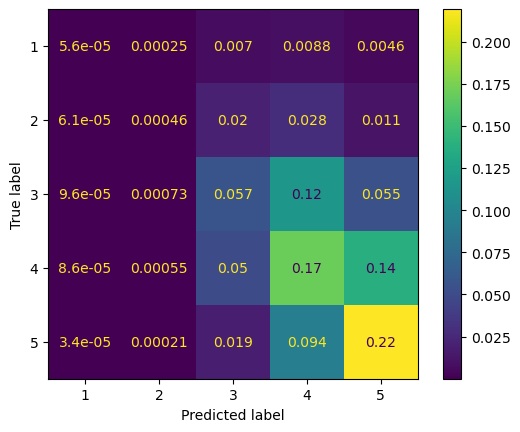

In [71]:
cm = confusion_matrix(test_y, predictions, labels=classifier1.classes_, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classifier1.classes_)
disp.plot()
plt.show()

In [73]:
precision_score(test_y, predictions, average='micro')

0.44677803657002113

Добавление векторного описания книг не смогло улучшить предскания модели.